# Field population Post modeling visualization

**Choice and no choice experiments combined**

Now we combine all modeling output and data to produce the manuscript figures

In [1]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("tidyverse", "mgcv", "MuMIn", "multcomp", "gratia", 
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","patchwork")

load_packages(packages)

i_am('README.md')

# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser



Attaching package: ‘gratia’


The following object is masked from ‘package:stringr’:

    boundary



Attaching package:

## Read in data

I am going to select columns that I will use just to keep the dataframes managable

In [26]:
# Choice experiment data

choice_raw_dat <- read_csv(here("data/raw/field_populations/IT_dat.csv"),show_col_types = FALSE) |>
    clean_names() |>
    mutate(across(c(population,sex,diet_pair,cage_no,low_p_diet,high_p_diet,notes_exclude_reason),~factor(.))) |>
    dplyr::select(population,diet_pair,sex,initial_mass_g,protein_consumed_g,carb_consumed_g) |>
    drop_na(protein_consumed_g,carb_consumed_g)

choice_pred_dat <- read_csv(here('data/processed/field_populations/choice_experiment_predictions.csv'),show_col_types = FALSE)

choice_dat <- choice_raw_dat |>
    left_join(choice_pred_dat,by=c('population','diet_pair','sex'))

# No choice experiment data

no_choice_raw_dat <- read_csv(here("data/raw/field_populations/confined_diet.csv"),show_col_types = FALSE)  |>
    clean_names() |>
    rename(
        diet = diet,
        sex = sex,
        initial_weight_g = locust_initial_weight_g,
        final_mass_g_dec3 = final_mass_g_5th_instar_recorded_on_dec_3,
        dev_time_with_5th_instar_days = development_time_with_days_in_5th_instar_for_those_not_yet_molted_days,
        specific_growth_rate_ln_mb = specific_growth_rate_ln_mb_final_mb_initial_time) |>
    dplyr::select(diet,sex,initial_weight_g,final_mass_g_dec3,dev_time_with_5th_instar_days,specific_growth_rate_ln_mb) |>
    drop_na(specific_growth_rate_ln_mb)

## I am taking the average over initial mass for simplicity sake
no_choice_pred_dat <- read_csv(here('data/processed/field_populations/no_choice_experiment_predictions.csv'),show_col_types = FALSE) |>
    group_by(diet,sex) |>
    summarize(pred_specific_growth_rate = mean(pred_specific_growth_rate),
           pred_development_time = mean(pred_development_time))

no_choice_dat <- no_choice_raw_dat |>
    left_join(no_choice_pred_dat,by=c('diet','sex'))


`summarise()` has grouped output by 'diet'. You can override using the
`.groups` argument.

## Figure 2

### Field population figure

-   panel a: choice intake target of two populations
-   panel b: specific growth rate on confined ‘no-choice’ diets
-   panel c: development time on confined ‘no-choice’ diets

In [29]:
panel_a <- choice_dat |>
    group_by(population) |>
    mutate(pred_carb = mean(pred_carb), pred_protein = mean(pred_protein)) |>
    ggplot(aes(x=protein_consumed_g,y=carb_consumed_g,fill=population)) + 
        geom_point(shape=21) +  
        geom_point(aes(x = pred_protein, y = pred_carb,fill=population), size=5,shape=21) +
        coord_equal(ratio=1) + 
        xlim(0,.055) + ylim(0,.055) + 
        theme_pubr() + 
        ylab("Carbohydrate consumed (g)") +
        xlab("Protein consumed (g)") + 
        scale_fill_met_d(name='Degas') +
        geom_abline(slope = 1,linetype=1,intercept=0) + 
        geom_abline(slope = 2,linetype=2,intercept=0)


panel_b <- no_choice_dat |>
    group_by(diet) |>
    mutate(pred_specific_growth_rate = mean(pred_specific_growth_rate),
          diet = factor(diet,levels = c("7p:35c","14p:28c","21p:21c","35p:7c"))) |>
    ggplot(aes(x=diet,y=specific_growth_rate_ln_mb)) +
        geom_point() +
        geom_point(aes(y=pred_specific_growth_rate),shape=23,size=5,fill="blue") +
        ylab(expression("Specific Growth Rate" ~ (day^-1))) +
        xlab("Diet") + 
        theme_pubr()


panel_c <- no_choice_dat |>
    group_by(diet) |>
    mutate(pred_development_time = mean(pred_development_time),
          diet = factor(diet,levels = c("7p:35c","14p:28c","21p:21c","35p:7c"))) |>
    ggplot(aes(x=diet,y=dev_time_with_5th_instar_days)) +
        geom_point() +
        geom_point(aes(y=pred_development_time),shape=24,size=5,fill="purple") +
        ylab("Development Time (days)") + 
        xlab("Diet") +  
        theme_pubr() 


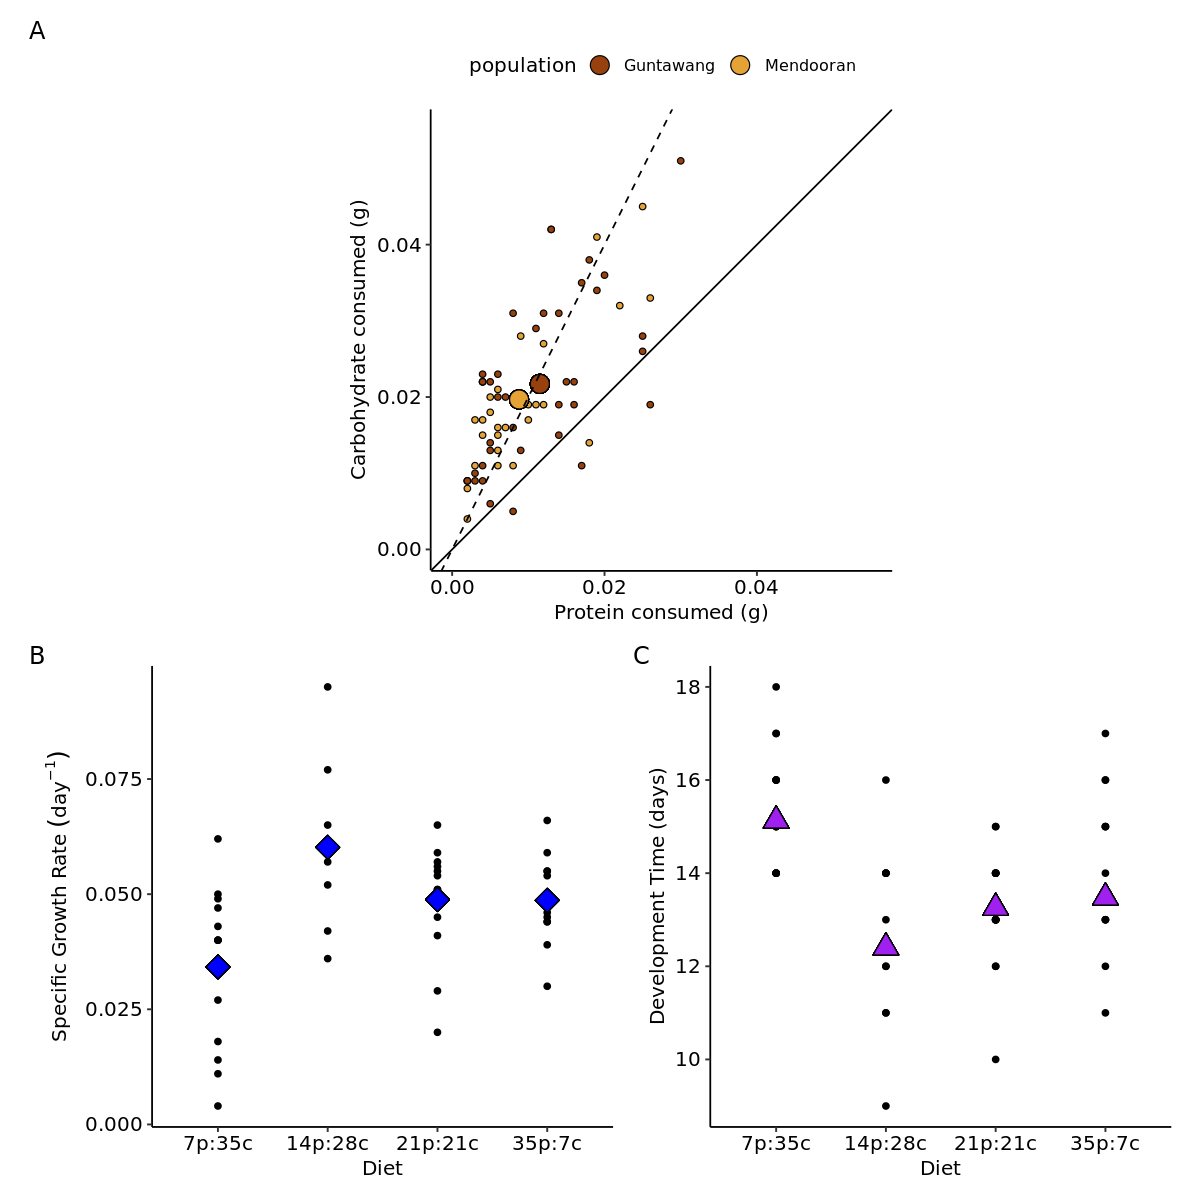

In [30]:

layout <- "
AA
BC
"

figure_2 <- panel_a + panel_b + panel_c + 
  plot_layout(design = layout) + plot_annotation(tag_levels = 'A')

figure_2

In [31]:
ggsave(figure_2,file=here('output/publication_figures/field_population_intake_target_figure.png'),width=10,height=10)

## Supplement Figure 3

### Field population figure – diet pairing and sex

-   panel a: diet pair
-   panel b: sex
-   panel c: specific growth rate – sex
-   panel d: development time – sex

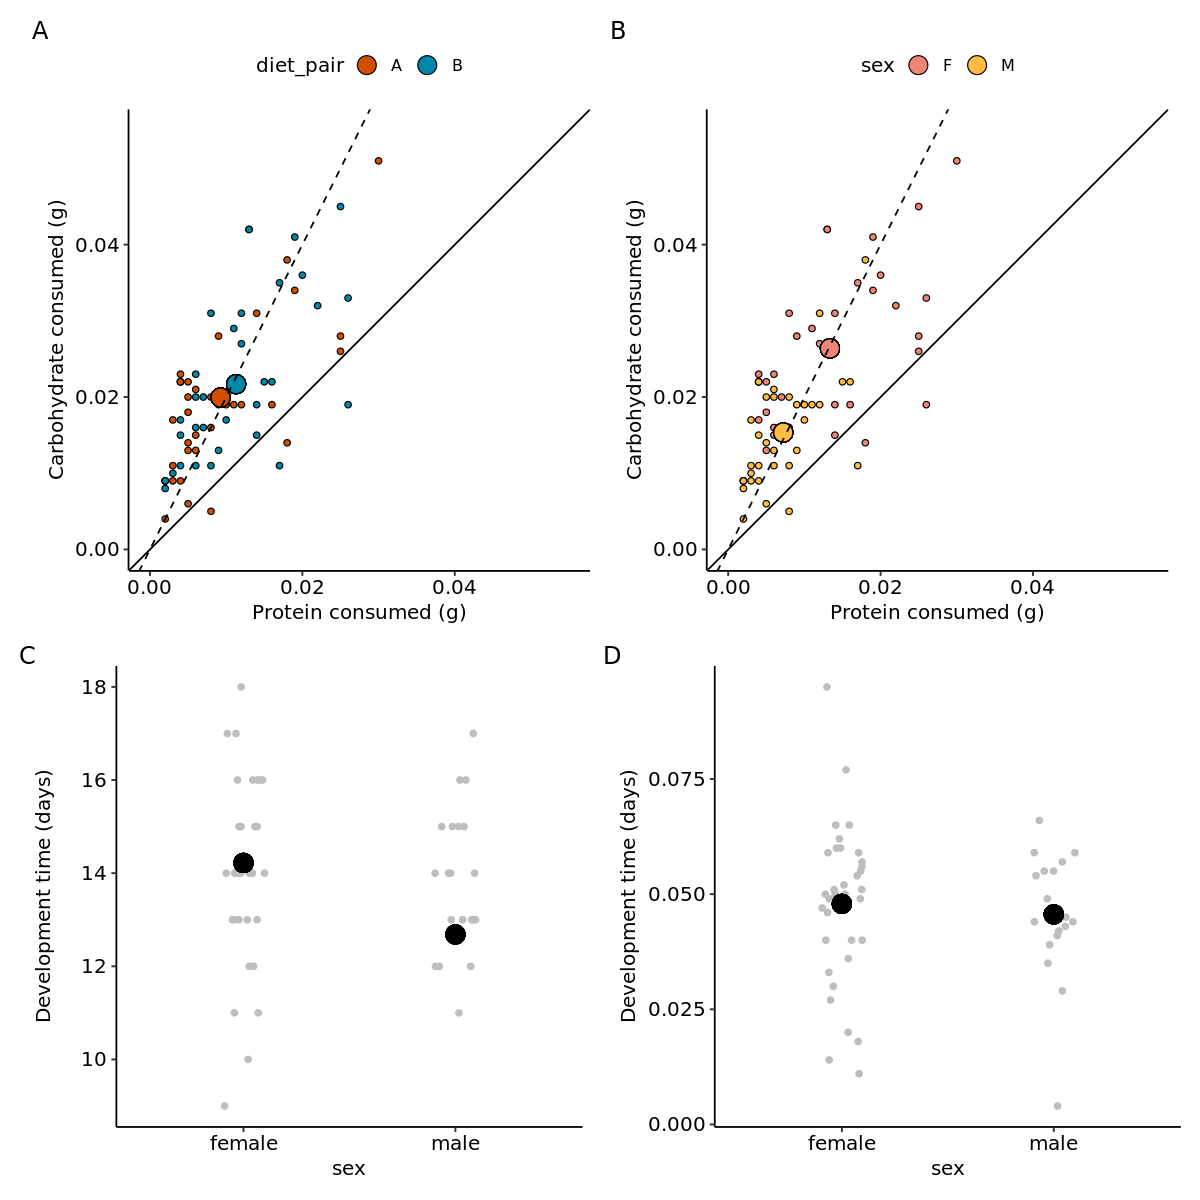

In [7]:
panel_a <- choice_dat |>
    group_by(diet_pair) |>
    mutate(pred_carb = mean(pred_carb), pred_protein = mean(pred_protein)) |>
    ggplot(aes(x=protein_consumed_g,y=carb_consumed_g,fill=diet_pair)) + 
        geom_point(shape=21) +  
        geom_point(aes(x = pred_protein, y = pred_carb,fill=diet_pair), size=5,shape=21) +
        coord_equal(ratio=1) + 
        xlim(0,.055) + ylim(0,.055) + 
        theme_pubr() + 
        ylab("Carbohydrate consumed (g)") +
        xlab("Protein consumed (g)") + 
        scale_fill_met_d(name='Johnson') +
        geom_abline(slope = 1,linetype=1,intercept=0) + 
        geom_abline(slope = 2,linetype=2,intercept=0)

panel_b <- choice_dat |>
    group_by(sex) |>
    mutate(pred_carb = mean(pred_carb), pred_protein = mean(pred_protein)) |>
    ggplot(aes(x=protein_consumed_g,y=carb_consumed_g,fill=sex)) + 
        geom_point(shape=21) +  
        geom_point(aes(x = pred_protein, y = pred_carb,fill=sex), size=5,shape=21) +
        coord_equal(ratio=1) + 
        xlim(0,.055) + ylim(0,.055) + 
        theme_pubr() + 
        ylab("Carbohydrate consumed (g)") +
        xlab("Protein consumed (g)") + 
        scale_fill_met_d(name='Cross') +
        geom_abline(slope = 1,linetype=1,intercept=0) + 
        geom_abline(slope = 2,linetype=2,intercept=0)

panel_c <- no_choice_dat |>
    group_by(sex) |>
    mutate(sex = case_when(sex == 'F' ~ 'female',TRUE ~ 'male'), 
           pred_development_time = mean(pred_development_time)) |>
    ggplot(aes(x=sex,y=dev_time_with_5th_instar_days)) + 
        geom_jitter(width=0.1,height=0,color='grey') +  
        geom_point(aes(x = sex, y = pred_development_time), size=5) +
        theme_pubr() + 
        ylab("Development time (days)") +
        xlab("sex") 

panel_d <- no_choice_dat |>
    group_by(sex) |>
    mutate(sex = case_when(sex == 'F' ~ 'female',TRUE ~ 'male'), 
           pred_specific_growth_rate = mean(pred_specific_growth_rate)) |>
    ggplot(aes(x=sex,y=specific_growth_rate_ln_mb)) + 
        geom_jitter(width=0.1,height=0,color='grey') +  
        geom_point(aes(x = sex, y = pred_specific_growth_rate), size=5) +
        theme_pubr() + 
        ylab("Development time (days)") +
        xlab("sex") 

supplement_figure_3 <- (panel_a + panel_b) / (panel_c + panel_d)  + plot_annotation(tag_levels = 'A')

supplement_figure_3

In [8]:
ggsave(supplement_figure_3,file=here('output/publication_figures/supplement_figure_3.png'),width=10,height=10)

## Maintext Table 1

### Field population choice model result table

Family: multivariate gaussian distribution link: identity SE: standard error.

In [9]:
mods <- readRDS(here("output/field_populations/model_objects/choice_experiment_models.rds"))

field_pop_mod <- mods$mod3

In [10]:
field_population_choice_model_result <- tidy(field_pop_mod,parametric=TRUE) |>
    dplyr::select(term,estimate,std.error,p.value) |>
    rename(variable = term,
           SE = std.error,
           `p-value` = p.value) |>
    mutate(variable = gsub('\\(|\\)','',variable),
           macronutrient = case_when(str_detect(variable,'.1') ~ 'protein', TRUE ~ 'carbohydrate'),
           variable = gsub('.1|population|sex|diet_pair','',variable),
           variable = case_when(variable == 'B' ~ 'diet pair B',variable == 'M' ~ 'male',TRUE ~ variable)) |>
    dplyr::select(macronutrient,variable,estimate,SE,`p-value`)

In [11]:
field_population_choice_model_result

In [12]:
write.csv(field_population_choice_model_result,
          file=here('output/publication_tables/field_population_choice_model_result.csv'),
          row.names=FALSE)

## Maintext Table 2

### Specific growth rate and development time model results

SE: standard error, EDF: estimated degrees freedom, DF: degrees freedom

In [13]:
mods <- readRDS(here("output/field_populations/model_objects/no_choice_experiment_models.rds"))

In [14]:
sgr_mod <- mods$sgr_models[[3]]
dev_mod <- mods$dev_models[[2]]

In [15]:
sgr_results <- tidy(sgr_mod,parametric=TRUE) |>
    dplyr::select(term,estimate,std.error,p.value) |>
    rename(variable = term,
           SE = std.error,
           `p-value` = p.value) |>
    mutate(variable = gsub('\\(|\\)|population|sex|diet','',variable),
           variable = gsub('M','male',variable)) |>
    dplyr::select(variable,estimate,SE,`p-value`) |>
    mutate(model = 'specific growth rate')

dev_results <- tidy(dev_mod,parametric=TRUE) |>
    dplyr::select(term,estimate,std.error,p.value) |>
    rename(variable = term,
           SE = std.error,
           `p-value` = p.value) |>
    mutate(variable = gsub('\\(|\\)|population|sex|diet','',variable),
           variable = gsub('M','male',variable)) |>
    dplyr::select(variable,estimate,SE,`p-value`)  |>
    mutate(model = 'development time')

sgr_dev_model_summary <- sgr_results |>
    rbind(dev_results)

In [16]:
sgr_dev_model_summary

In [17]:
write.csv(sgr_dev_model_summary,
          file=here('output/publication_tables/field_population_no_choice_sgr_dev_result.csv'),
          row.names=FALSE)

## Model Selection Criteria tables

-   choice experiment model selection critera table
-   no choice experiment model selection critera table – specific growth rate
-   no choice experiment model selection critera table – development time

### Choice experiment table

In [18]:
choice_selection <- read_csv(here("output/field_populations/choice_experiment_model_selection_criteria_results.csv"),show_col_types = FALSE)

choice_selection_table <- choice_selection |>
    mutate(model = case_when(model == 'mod1' ~ 'macronutrient ~ population + diet_pair + sex + s(initial_mass_g, k=30)',
                             model == 'mod2' ~ 'macronutrient ~ population + diet_pair + sex + initial_mass_g',
                             model == 'mod3' ~ 'macronutrient ~ population + diet_pair + sex',
                             model == 'mod4' ~ 'macronutrient ~ 1'),
        across(where(is.numeric),~round(.,4))) |>
    dplyr::select(model,deltaBIC,deltaAIC,deltaAICc)


In [19]:
write.csv(choice_selection_table,
          file=here('output/publication_tables/field_population_choice_experiment_model_selection_criteria.csv'),
          row.names=FALSE)

### no choice experiment

In [20]:
no_choice_selection <- read_csv(here("output/field_populations/no_choice_experiment_model_selection_criteria_results.csv"),show_col_types = FALSE)

In [21]:
no_choice_selection_specific_growth_rate_table <- no_choice_selection |>
    filter(physiology_parameter == 'specific_growth_rate') |>
    mutate(model = case_when(model == 'models[[1]]' ~ 'specific growth rate ~ population + diet_pair + sex + s(initial_mass_g, k=15)',
                             model == 'models[[2]]' ~ 'specific growth rate ~ population + diet_pair + sex + initial_mass_g',
                             model == 'models[[3]]' ~ 'specific growth rate ~ population + diet_pair + sex',
                             model == 'models[[4]]' ~ 'specific growth rate ~ 1'),
        across(where(is.numeric),~round(.,4))) |>
    dplyr::select(model,deltaBIC,deltaAIC,deltaAICc)

no_choice_selection_development_time_table <- no_choice_selection |>
    filter(physiology_parameter == 'development_time') |>
    mutate(model = case_when(model == 'models[[1]]' ~ 'development time ~ population + diet_pair + sex + s(initial_mass_g, k=15)',
                             model == 'models[[2]]' ~ 'development time ~ population + diet_pair + sex + initial_mass_g',
                             model == 'models[[3]]' ~ 'development time ~ population + diet_pair + sex',
                             model == 'models[[4]]' ~ 'development time ~ 1'),
        across(where(is.numeric),~round(.,4))) |>
    dplyr::select(model,deltaBIC,deltaAIC,deltaAICc)
    

In [22]:
write.csv(no_choice_selection_specific_growth_rate_table,
          file=here('output/publication_tables/field_population_no_choice_specific_growth_rate_model_selection_criteria.csv'),
          row.names=FALSE)

write.csv(no_choice_selection_development_time_table,
          file=here('output/publication_tables/field_population_no_choice_development_time_model_selection_criteria.csv'),
          row.names=FALSE)

## Posthoc comparisons

In [23]:
development_time_contrasts <- read_csv(here("output/field_populations/no_choice_experiment_development_time_emm_contrasts.csv"),show_col_types = FALSE)
specific_growth_rate_contrasts <- read_csv(here("output/field_populations/no_choice_experiment_specific_growth_rate_emm_contrasts.csv"),show_col_types = FALSE)



In [24]:
development_time_contrasts_table <- development_time_contrasts |>
    dplyr::select(contrast,estimate,std.error,adj.p.value) |>
    mutate(across(where(is.numeric),~round(.,4)),model = 'development time') |>
    rename(comparisons = contrast,
           SE = std.error,
           `adjusted p-value` = adj.p.value) 

specific_growth_rate_contrasts_table <- specific_growth_rate_contrasts |>
    dplyr::select(contrast,estimate,std.error,adj.p.value) |>
    mutate(across(where(is.numeric),~round(.,4)),model = 'specific growth rate')  |>
    rename(comparisons = contrast,
           SE = std.error,
           `adjusted p-value` = adj.p.value)

posthoc_table <- rbind(development_time_contrasts_table,specific_growth_rate_contrasts_table)

In [25]:
write.csv(posthoc_table,
          file=here('output/publication_tables/field_population_no_choice_sgr_dev_posthoc_comparison_results.csv'),
          row.names=FALSE)